# KMeans Clustering Model
Question of interest: \
Can we group facilities based on water system characteristics, contaminant presence, and local socioeconomic factors — and do these k means clusters reveal patterns of contamination risk or environmental injustice?

## Preprocessing the Data

In [131]:
# Import necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os

In [118]:
"""Load data"""

# List of file names
files = [f"df{i}.csv" for i in range(1, 13)]
dfs = [pd.read_csv(f'https://github.com/chencheny249/DataMiningProjSpring2025/blob/20232a7cfac86818960cff6e1cae52db708d0bf3/{file}?raw=true', sep=",", encoding="latin1") for file in files]

df = pd.concat(dfs, ignore_index=True)

print(df.shape)

(1499860, 22)


In [119]:
df.head()

,County,PWSName,Size,FacilityName,FacilityWaterType,SamplePointName,CollectionDate,SampleID,Contaminant,Region,...,Month,MRL_Exceeded,MRL_Not_Exceeded,Relative_MRL,MCL_Exceeded,MCL_Not_Exceeded,Relative_MCL,Median_Income,Child_Poverty_Rate,Poverty_Rate
0,Juneau,CITY AND BOROUGH OF JUNEAU,L,Salmon Creek Reservoir TP,SW,Salmon Creek DS EP,2024-11-04,32403661003,PFNA,10,...,11,0,1,0.0,0,1,0.0,NaN,NaN,NaN
1,Juneau,CITY AND BOROUGH OF JUNEAU,L,Salmon Creek Reservoir TP,SW,Salmon Creek DS EP,2024-11-04,32403661003,PFUnA,10,...,11,0,1,0.0,0,1,0.0,NaN,NaN,NaN
2,Juneau,CITY AND BOROUGH OF JUNEAU,L,Salmon Creek Reservoir TP,SW,Salmon Creek DS EP,2024-11-04,32403661003,NEtFOSAA,10,...,11,0,1,0.0,0,1,0.0,NaN,NaN,NaN
3,Juneau,CITY AND BOROUGH OF JUNEAU,L,Salmon Creek Reservoir TP,SW,Salmon Creek DS EP,2024-11-04,32403661003,PFHpS,10,...,11,0,1,0.0,0,1,0.0,NaN,NaN,NaN
4,Juneau,CITY AND BOROUGH OF JUNEAU,L,Salmon Creek Reservoir TP,SW,Salmon Creek DS EP,2024-11-04,32403661003,9Cl-PF3ONS,10,...,11,0,1,0.0,0,1,0.0,NaN,NaN,NaN


In [ ]:
# Extract the relevant features
features = [
    'FacilityWaterType', 'Contaminant', 'Relative_MCL',
    'Median_Income', 'Child_Poverty_Rate', 'Poverty_Rate',
    'MCL_Exceeded', 'County'
]

# Make a separate clean df - for visualizations later 
df_subset = df[features].dropna()
df_sample = df_subset.sample(n=10000, random_state=1234)

# Preserve a separate version
df_original = df_sample.copy()

# Working df
df_model = df_sample.copy()


In [ ]:
# Encode categorical variables
le_facility = LabelEncoder()
df_model['FacilityWaterType'] = le_facility.fit_transform(df_model['FacilityWaterType'])

le_contaminant = LabelEncoder()
df_model['Contaminant'] = le_contaminant.fit_transform(df_model['Contaminant'])

le_County = LabelEncoder()
df_model['County'] = le_County.fit_transform(df['County'])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[features])

# Split the data into features and target
X = df_model.drop(columns=['MCL_Exceeded'], axis =1)
y = df_model['MCL_Exceeded']



In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['MCL_Exceeded'], test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Test the KMeans Model

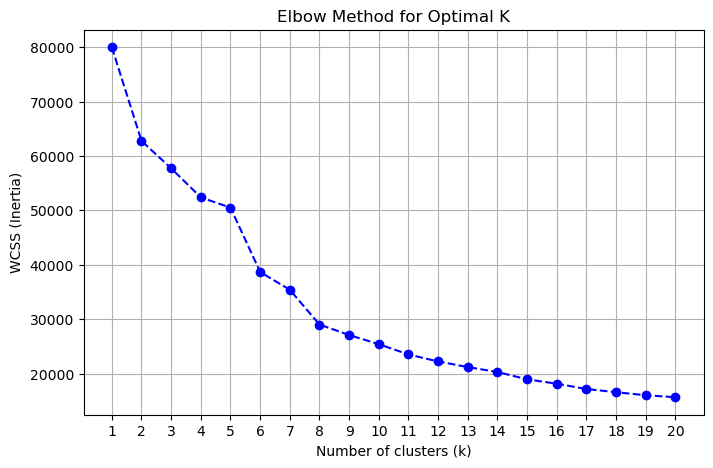

In [ ]:
# Use the elbow method to find the optimal k value
wcss = []
K = range(1, 21)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

# Plot the Elbow
plt.figure(figsize=(8, 5))
plt.plot(K, wcss, 'bo--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(K)
plt.grid(True)
plt.show()



In [132]:
model = KMeans(n_clusters=15, random_state=1234)
y_kmeans = model.fit_predict(X_scaled)


In [133]:
df_model['Cluster'] = y_kmeans

To preprocess the data for the KMeans clustering algorithm, we first read in the dataset and selected the variables of interest for this specific research question. In this case, we are curious about the facilities, contamination levels, regions, and socicoeconomic factors. Next, rows with missing information for any of these features were dropped, and a smaller sample of the dataset was used in the final model for faster processing. Next the categorical variables `FacilityWaterType`, `Contaminant`, and `County` were label encoded to adhere to the model, and the features were split into a training/test set and standardized. 

Next, we want to use the elbow method on the data to determine the number of clusters what would be beneficial, and gather the most amount of information from the data. We can determine this by looking at the elbow plot, and finding the point where the line starts to flatten, indicating that the amount of clusters at that point is sufficient for explaining the information in the dataset. 

## Interpret and Visualize the Output

In [134]:
# Cluster sizes
df_model['Cluster'].value_counts().sort_index()

Cluster
0      797
1      851
2      640
3      115
4     1176
5     1231
6      762
7       14
8      475
9        2
10     665
11     659
12     876
13     915
14     822
Name: count, dtype: int64

In [135]:
# Means of each cluster
df_model.groupby('Cluster')[features].mean()

,FacilityWaterType,Contaminant,Relative_MCL,Median_Income,Child_Poverty_Rate,Poverty_Rate,MCL_Exceeded,County
Cluster,,,,,,,,
0,2.959849,4.929737,0.001161,81887.089084,14.240652,11.318946,0.0,561.616060
1,1.005875,18.977673,0.001146,53721.297297,24.594125,17.790364,0.0,751.823737
2,2.976562,18.609375,0.006758,81366.018750,12.887031,10.328437,0.0,214.417188
3,1.739130,17.408696,1.827391,89705.826087,14.273043,11.117391,1.0,542.217391
4,0.977891,21.221939,0.002105,79228.082483,13.681122,10.859439,0.0,756.721939
5,2.986190,16.376929,0.003412,53797.252640,24.067425,17.419171,0.0,518.680747
6,1.000000,13.473753,0.000984,88575.950131,10.323491,8.770079,0.0,240.346457
7,1.357143,18.357143,10.017857,63343.000000,20.585714,14.821429,1.0,407.071429
8,1.484211,16.389474,0.000000,42392.602105,36.752632,26.422947,0.0,485.720000


After looking at these clusters and the means of each feature - there are some interesting observations related to income, poverty levels, and MCL levels: 
* Cluster 9 only had two samples, so these are likely outliers. However, this cluster had an extremely high relative MCL of around 46.75, and also a higher median income. This *could* mean that contamination isn't strictly tied to poverty, but this is also a broad generalizaton and is likely more of a rare case. 
* Cluster 7 also had a high relative MCL around 10.01, but again not many samples in this cluster (only 14) so it would be another generalization. This cluster, similarly to cluster 8, also had a relatively high median income, indicating that poverty is not strictly tied to clean water, but this is rare in this dataset/clusters.
* Cluster 3, however, likely holds more significance. There are 115 samples here so it has a higher impact, and has a relative MCL value of 1.83 (not as high as for clusters 8 and 3, but large enough to exceed the MCL level). It also has a more moderate median income and poverty level, thus indicating relatively unclean water for middle class incomes. 
* Cluster 11 is also interesting to point out, since it has a very high median income and very low poverty rate, while also maintaing one of the lowest MCL levels. This is likely the most "safe" water cluster. 
* Cluster 5, on the other hand, had a high poverty rate and low median income. The MCL levels did not exceed the threshold, but was still relatively high. 

Next, we want to evaluate the perfomance of this model, using the Silhouette Score and Davies-Bouldin Index metrics

In [136]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# y_kmeans holds the cluster labels
silhouette = silhouette_score(X_scaled, y_kmeans)
davies_bouldin = davies_bouldin_score(X_scaled, y_kmeans)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")

Silhouette Score: 0.22731248705602644
Davies-Bouldin Index: 1.0313603863443017


The Silhouette Score and the Davies-Bouldin score indicate that the model isn't great. Ideally, a Silhouette score (which measures how similar a point is to its own cluster) should be above 0.5 to be considered well-clustered, and the Davies-Bouldin index (which measures the average similarity of each cluster, compared to the cluster next to it) should be low. Given that this model did not perform specifically well, it may be worth tuning further or implementing a different model. It should be noted that KMeans clustering assumes spherical, equally sized clusters, which are relatively uncommon in environmental or socioeconomic data. 

### Testing DBSCAN Clustering 


In [137]:
scores = []

for k in range(12, 18):
    model = KMeans(n_clusters=k, random_state=1234)
    labels = model.fit_predict(X_scaled)
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    scores.append((k, sil_score, db_score))

for k, sil, db in scores:
    print(f"k={k} | Silhouette Score: {sil:.4f}, Davies-Bouldin: {db:.4f}")

k=12 | Silhouette Score: 0.2062, Davies-Bouldin: 1.0930
k=13 | Silhouette Score: 0.2193, Davies-Bouldin: 1.0896
k=14 | Silhouette Score: 0.2257, Davies-Bouldin: 1.0559
k=15 | Silhouette Score: 0.2273, Davies-Bouldin: 1.0314
k=16 | Silhouette Score: 0.2319, Davies-Bouldin: 1.0385
k=17 | Silhouette Score: 0.2338, Davies-Bouldin: 1.0494


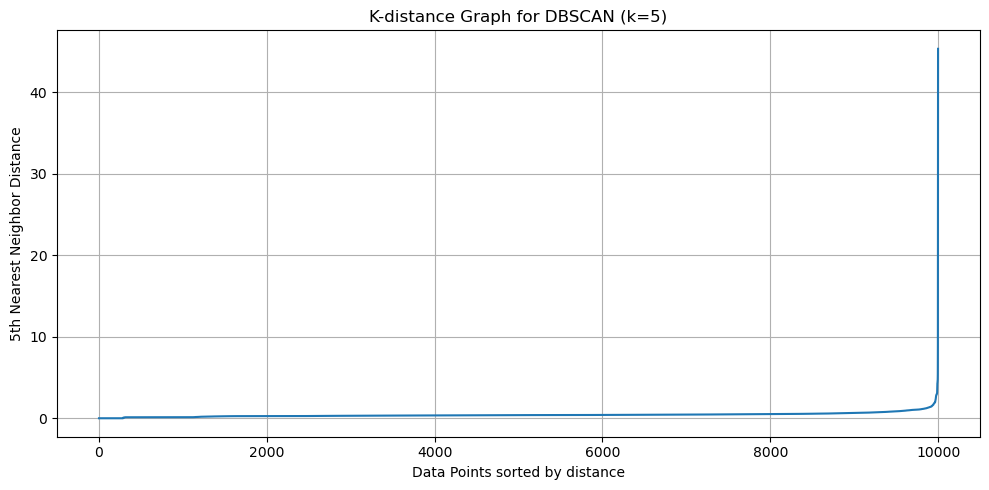

In [138]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# First, plot the k-nearest neighbors distances to help choose epsilon (eps) for DBSCAN
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances and plot the knee to identify a good eps
sorted_distances = np.sort(distances[:, 4])  # 5th nearest neighbor distance
plt.figure(figsize=(10, 5))
plt.plot(sorted_distances)
plt.title("K-distance Graph for DBSCAN (k=5)")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [139]:
for eps in [3000, 5000, 7000, 8500, 9500]:
    db = DBSCAN(eps=eps, min_samples=10)
    labels = db.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"eps={eps} → Clusters: {n_clusters}, Noise points: {n_noise}")
    
    if n_clusters > 1:
        silhouette = silhouette_score(X_scaled, labels)
        dbi = davies_bouldin_score(X_scaled, labels)
        print(f"Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {dbi:.4f}")
    print("------")

eps=3000 → Clusters: 1, Noise points: 0
------
eps=5000 → Clusters: 1, Noise points: 0
------
eps=7000 → Clusters: 1, Noise points: 0
------
eps=8500 → Clusters: 1, Noise points: 0
------
eps=9500 → Clusters: 1, Noise points: 0
------


In [140]:
# Run DBSCAN
dbscan = DBSCAN(eps=10000, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

In [141]:
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

Estimated number of clusters: 1
Estimated number of noise points: 0


DBSCAN only produces one cluster no matter the value of `eps` so, given the clustering algorithms we know of so far, KMeans still gives us the most information about this dataset. Lets analyze this data further with some visualizations. 

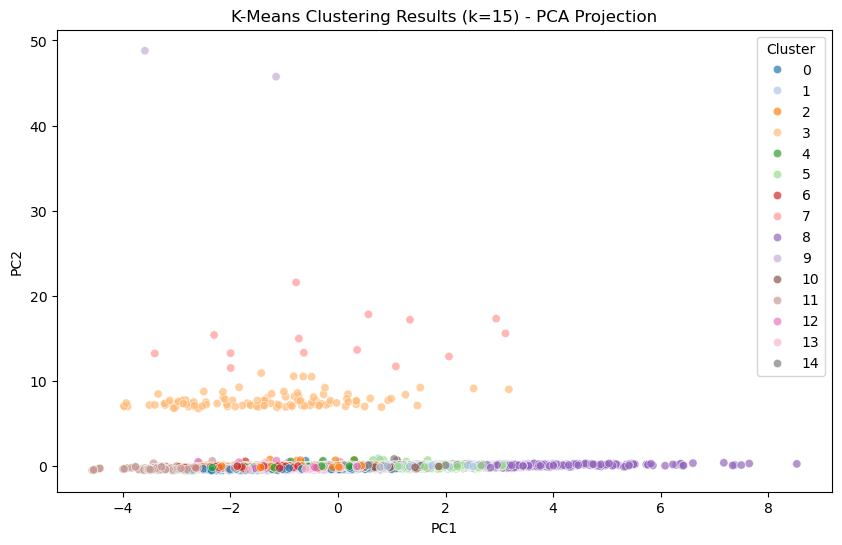

In [142]:
# Visualize the clusters
# Reduce to 2 principal components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
df_viz = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_viz['Cluster'] = y_kmeans

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_viz, x='PC1', y='PC2', hue='Cluster', palette='tab20', legend='full', alpha=0.7)
plt.title('K-Means Clustering Results (k=15) - PCA Projection')
plt.show()

In [143]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))

Explained variance ratio: [0.33730673 0.18573779]
Total variance explained: 0.5230445192510167


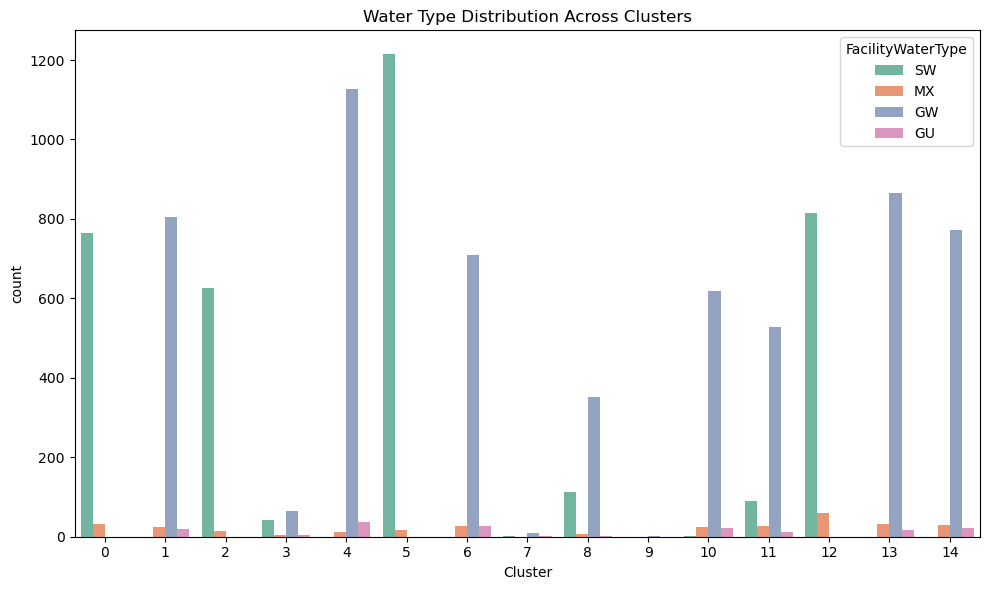

In [144]:
# Add the original water type back to the sampled df

# Attach cluster labels to df_original for plotting
df_original['Cluster'] = df_model['Cluster']

# Plot using original (unencoded) values
plt.figure(figsize=(10, 6))
sns.countplot(data=df_original, x='Cluster', hue='FacilityWaterType', palette='Set2')
plt.title("Water Type Distribution Across Clusters")
plt.legend(title='FacilityWaterType')
plt.tight_layout()
plt.show()

Lets look at the same clusters of interest from the table above to determine the influence of water type: 

* Cluster 9 is groundwater
* Cluster 7's highest water type is also groundwater. 
* Cluster 3's highest water type is ground water. 
* Cluster 12 highest water type is surface water.
* Cluster 5 highest water type is surface water. 

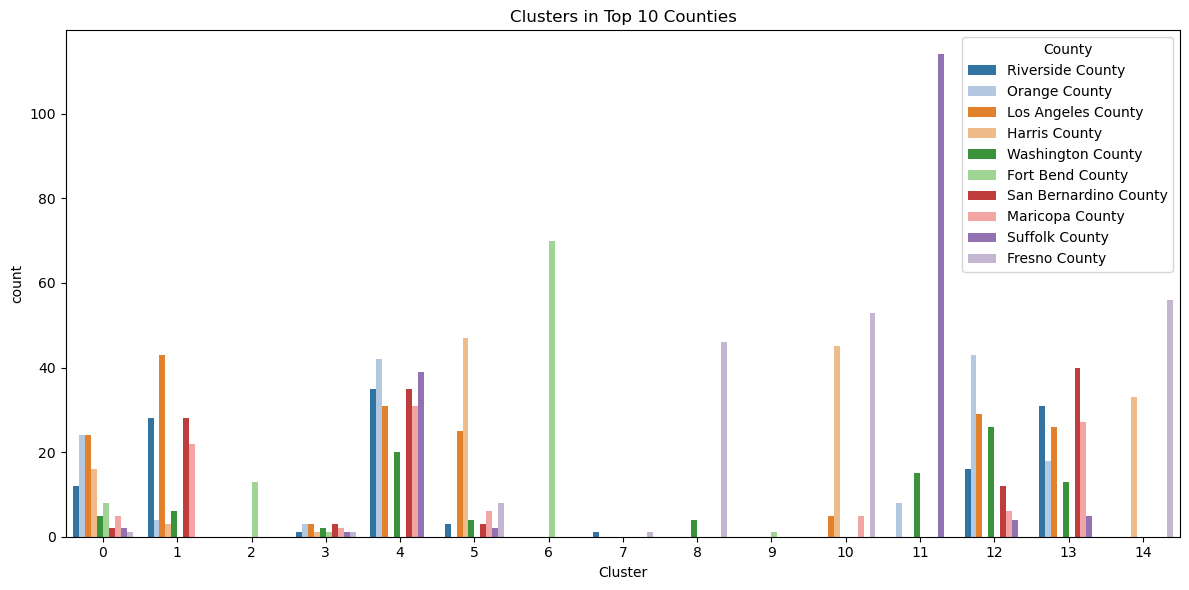

In [146]:
top_counties = df_original['County'].value_counts().head(10).index
df_filtered = df_original[df_original['County'].isin(top_counties)]

plt.figure(figsize=(12, 6))
sns.countplot(data=df_filtered, x='Cluster', hue='County', palette='tab20')
plt.title("Clusters in Top 10 Counties")
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Lets look at the same clusters of interest from the table above to determine the influence of region: 

* Cluster 9 is Fort Bend County (Texas)
* Cluster 7 is Riverside and Fresno (California and Texas)
* Cluster 3 is Orange County, Los Angeles County, and San Bernardino County (all California). 
* Cluster 11 is Washington County (Minnesota).
* Cluster 5 is Harris County (Texas). 

